# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

#pd.options.display.max_rows = 999

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.describe())
print('\n')
print('azdias.dtypes')
print(azdias.dtypes)
print('\n')
print('FEATURE INFO')
print(feat_info)


            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

def parse_missing_values(missing_values):
    missing_values = missing_values[1:-1].split(',')
    missing_values = list(filter(None, missing_values))
    
    for i, v in enumerate(missing_values):
        try:
            missing_values[i] = int(v)
        except:
            pass
    
    return missing_values

def fill_missing_with_nan(df, in_place=False):
    if not in_place:
        df = df.copy()
    
    for index, row in feat_info.iterrows():
        feature = row['attribute']
        missing_values = parse_missing_values(row['missing_or_unknown'])
    
        # Replace all missing values of column with NaN
        df.loc[(df[feature].isin(missing_values)), feature] = np.nan
        
    return df
    

azdias_missing = fill_missing_with_nan(azdias)

print('azdias.dypes')
print(azdias.dtypes)
print('\n')
print('azdias_missing.dypes')
print(azdias_missing.dtypes)

azdias.dypes
AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int

In [5]:
# Compare how we transformed a int64 column to a float64 column by adding np.nan
ager_typ = pd.DataFrame([azdias['AGER_TYP'], azdias_missing['AGER_TYP']]).transpose()
print(ager_typ)
print(type(np.nan))

        AGER_TYP  AGER_TYP
0           -1.0       NaN
1           -1.0       NaN
2           -1.0       NaN
3            2.0       2.0
4           -1.0       NaN
5            3.0       3.0
6           -1.0       NaN
7           -1.0       NaN
8           -1.0       NaN
9           -1.0       NaN
10           0.0       NaN
11          -1.0       NaN
12          -1.0       NaN
13          -1.0       NaN
14          -1.0       NaN
15           1.0       1.0
16          -1.0       NaN
17          -1.0       NaN
18          -1.0       NaN
19          -1.0       NaN
20          -1.0       NaN
21          -1.0       NaN
22          -1.0       NaN
23          -1.0       NaN
24          -1.0       NaN
25          -1.0       NaN
26          -1.0       NaN
27          -1.0       NaN
28          -1.0       NaN
29           2.0       2.0
...          ...       ...
891191       1.0       1.0
891192      -1.0       NaN
891193       2.0       2.0
891194      -1.0       NaN
891195       2.0       2.0
8

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

def get_na_percentage(data):
    return (data[data.columns[data.isnull().any()]].isnull().sum() / data.shape[0]).sort_values(ascending=False)

feature_na_percentage = get_na_percentage(azdias_missing)

In [7]:
# Print out the all columns with missing values (from most missing to least)
print(f'Features with Missing Values: {len(feature_na_percentage)}')
print(feature_na_percentage)

Features with Missing Values: 61
TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_A

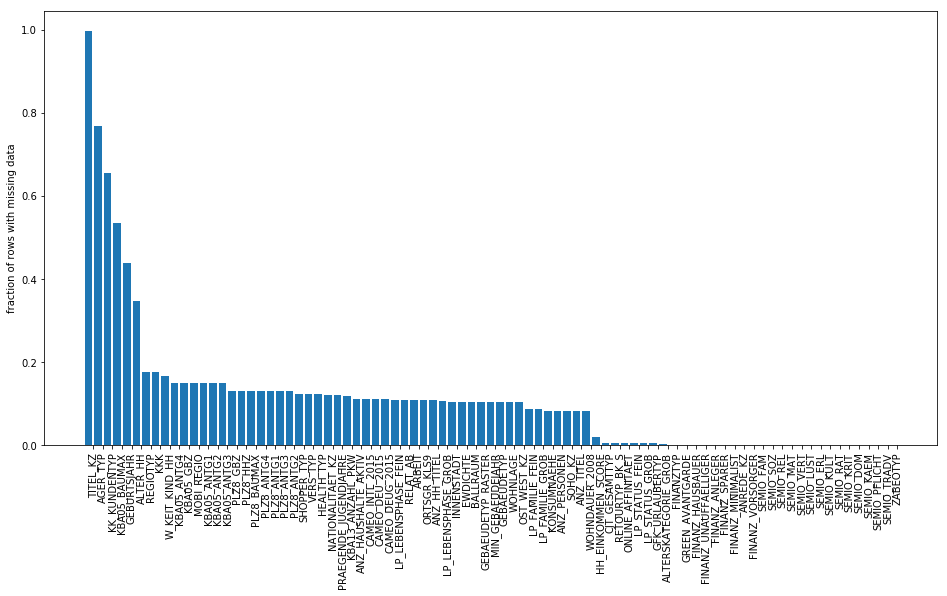

In [8]:
# Investigate patterns in the amount of missing data in each column.
def show_missing_amts(df):
    null_counts = df.isnull().sum()/len(df)
    null_counts = null_counts.sort_values(ascending=False)
    plt.figure(figsize=(16,8))
    plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
    plt.ylabel('fraction of rows with missing data')
    plt.bar(np.arange(len(null_counts)),null_counts)
    
show_missing_amts(azdias_missing)

In [9]:
# Drop features with 15% or more missing values
def na_features_below_threshold(feature_na_percentage, threshold=.15):
    na_features = []
    for feature, na_perc in feature_na_percentage.items():
        if na_perc >= threshold:
            na_features.append(feature)
    
    return na_features


na_features = na_features_below_threshold(feature_na_percentage)
print(len(na_features))
na_features

9


['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH',
 'REGIOTYP',
 'KKK',
 'W_KEIT_KIND_HH']

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH,REGIOTYP,KKK,W_KEIT_KIND_HH
count,2160.000000,205378.000000,306609.000000,414697.000000,498903.000000,580954.000000,733157.000000,733157.000000,743233.000000
mean,1.318519,1.743410,3.410640,2.539534,1967.102689,15.291805,4.472086,2.723384,4.147141
std,0.999504,0.674312,1.628844,1.693151,17.795208,3.800536,1.836357,0.979867,1.784211
min,1.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1955.000000,13.000000,3.000000,2.000000,3.000000
50%,1.000000,2.000000,3.000000,1.000000,1968.000000,16.000000,5.000000,3.000000,4.000000
75%,1.000000,2.000000,5.000000,4.000000,1981.000000,18.000000,6.000000,3.000000,6.000000
max,5.000000,3.000000,6.000000,5.000000,2017.000000,21.000000,7.000000,4.000000,6.000000


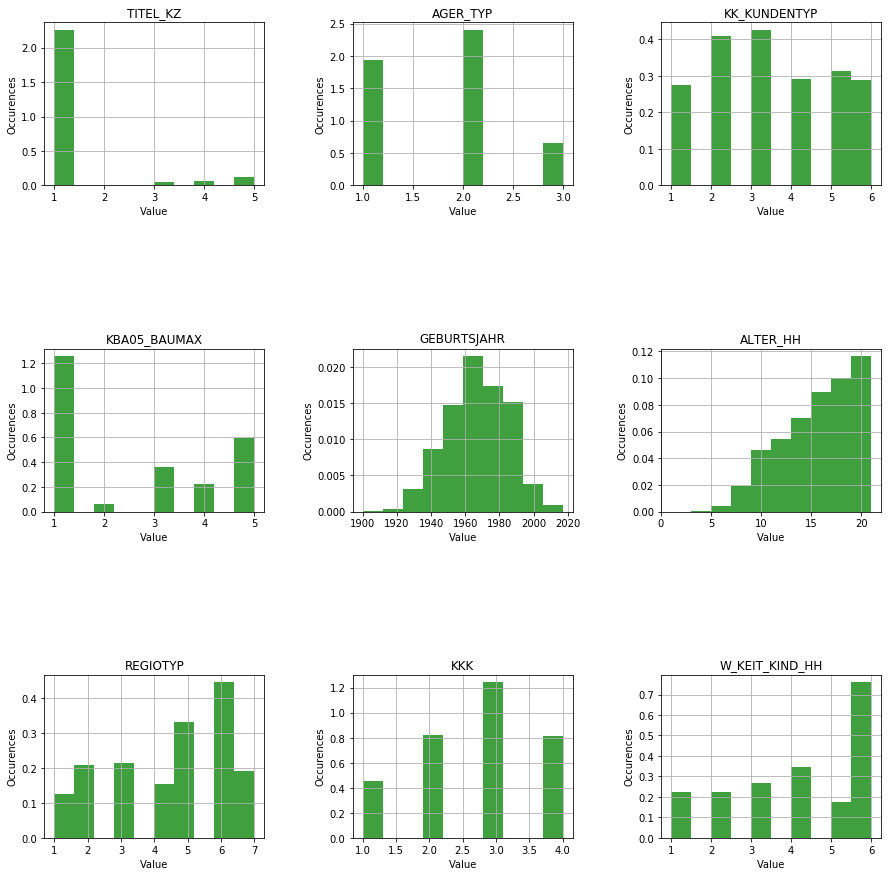

In [10]:
# Investigate any patterns in the features we are removing

def histogram_without_na(col):
    n, bins, patches = plt.hist(col.dropna(), density=True, facecolor='g', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Occurences')
    plt.title(col.name)
    plt.grid(True)

def show_features_histograms(df, features, grid_cols=3):
    rows = math.ceil(len(features)/grid_cols)
    width = 15
    height = width * rows / 3
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(hspace=1, wspace=0.4)
    for i, feature in enumerate(features):
        fig.add_subplot(rows, grid_cols, i+1)
        histogram_without_na(df[feature])
        
show_features_histograms(azdias_missing, na_features)

na_features_only = azdias_missing.filter(na_features)
na_features_only.describe()

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_prune_high_na = azdias_missing.drop(axis=1, columns=na_features)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The dataset was found to be comprised of 61 features that contained missing data.  Feature missing values made up 0.3% to 99.8% of each column's values. We decided to drop columns with >=15% missing values. Out of all the features that had missing values over the maximum allowed threshold, we noticed non-gaussian distributions in all but one of them, `GEBURTSJAHR`.  In others such as `TITEL_KZ` and `KBA05_BAUMAX`, there was very low variance in the range of values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

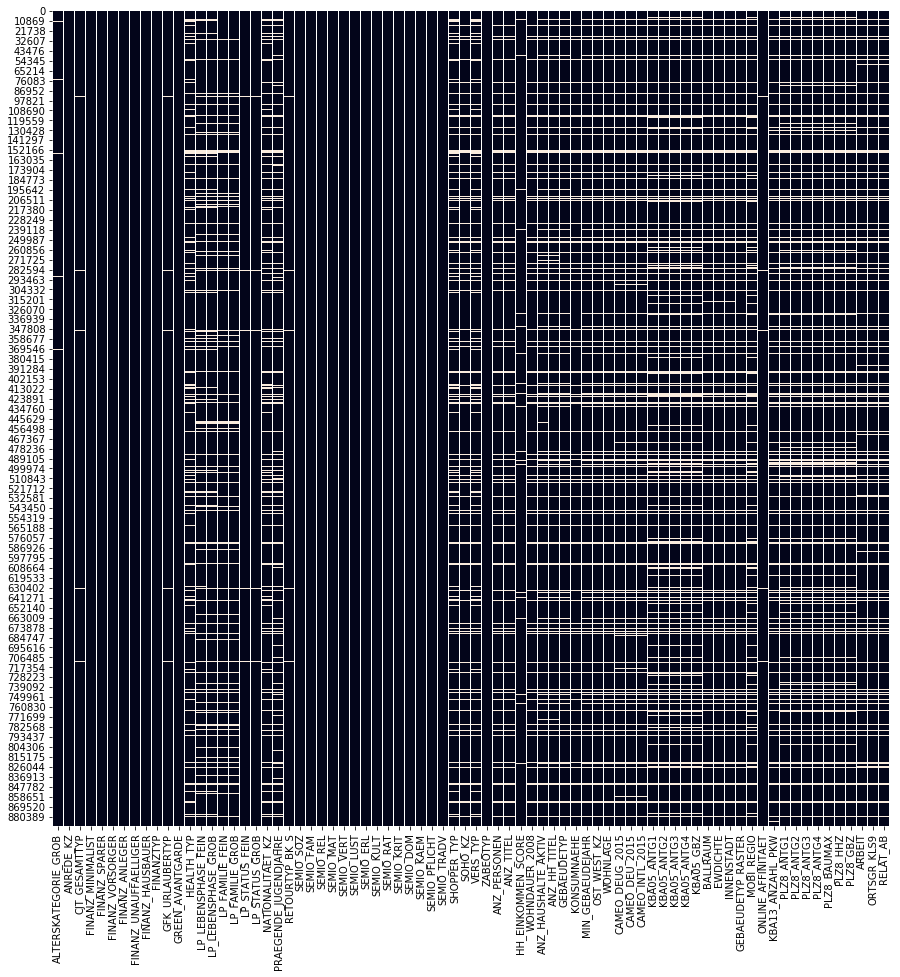

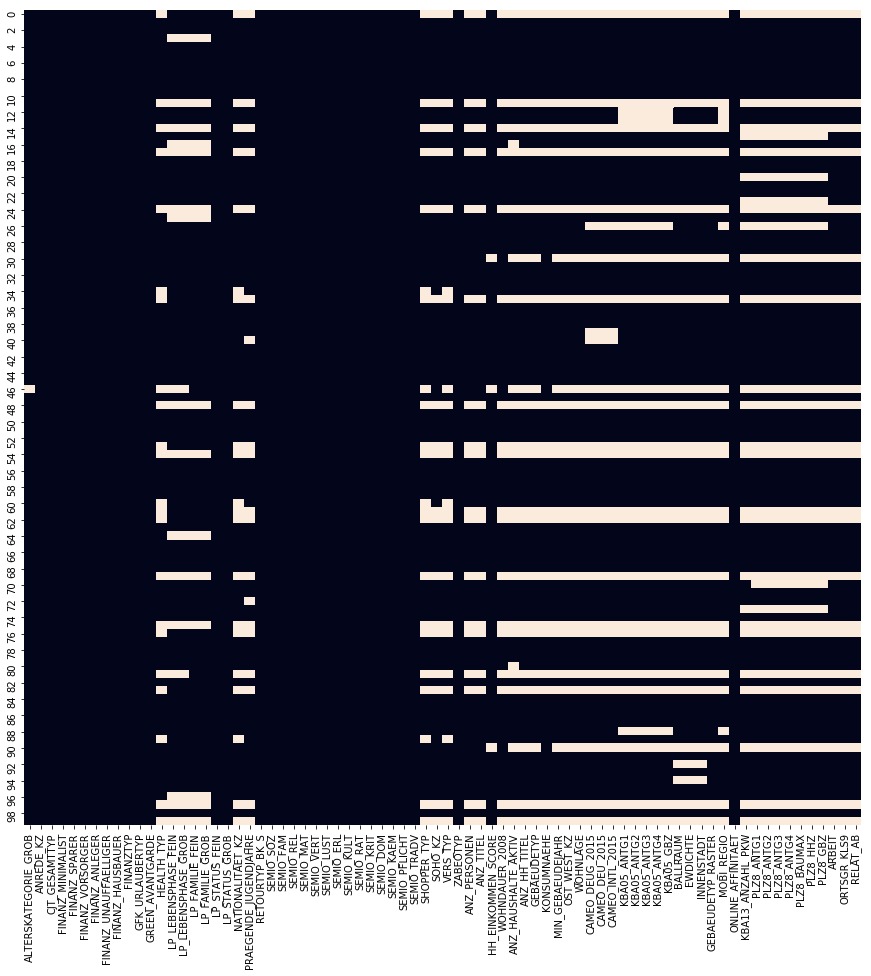

In [12]:
# How much data is missing in each row of the dataset?
def viz_na_heatmap(df):
    plt.figure(figsize=(15,15))
    sns.heatmap(df.isnull(), cbar=False)
    
viz_na_heatmap(azdias_prune_high_na)
viz_na_heatmap(azdias_prune_high_na[:100])

### Heatmap reveals missing features pattern

Looking at the heatmap of missing features, there seems to be a pattern that there are rows with the same missing features.

### Optimizing `get_rows_missing`

This piece of code was wreaking havoc on our pipeline efficiency.  So much that it needed its own optimization deep dive.

In [13]:
# Get rows each with their respective missing values percentage
# TODO: This is very slow, can we optimize this?
def get_rows_missing_iloc(df):
    missing_percs = []
    col_count = df.shape[1]
    for i in range(len(df.index)):
        perc = df.iloc[i].isnull().sum() / col_count
        missing_percs.append(perc)
    
    return pd.DataFrame(missing_percs, columns=['missing_percent'])

In [14]:
# Using iterrows()
def get_rows_missing_iterrows(df):
    missing_percs = []
    col_count = df.shape[1]
    for index, row in df.iterrows():
        perc = row.isnull().sum() / col_count
        missing_percs.append(perc)
    
    return pd.DataFrame(missing_percs, columns=['missing_percent'])

In [15]:
def get_rows_missing_apply(df):
    col_count = df.shape[1]
    return pd.DataFrame(df.apply(lambda row: (row.isnull().sum() / col_count), axis=1), columns=['missing_percent'])

In [16]:
# Benchmark
bench_row_count = 100
%timeit get_rows_missing_iloc(azdias_prune_high_na[:bench_row_count])
%timeit get_rows_missing_iterrows(azdias_prune_high_na[:bench_row_count])
%timeit get_rows_missing_apply(azdias_prune_high_na[:bench_row_count])

46 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.4 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.2 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
rows_missing = get_rows_missing_apply(azdias_prune_high_na)
rows_missing

,missing_percent
0,0.526316
1,0.000000
2,0.000000
3,0.052632
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [18]:
# Split rows that have missing value percentage above threshold
def split_rows_missing(df, rows_missing, threshold=.3):
    return (
        df.loc[rows_missing['missing_percent'] < threshold],
        df.loc[rows_missing['missing_percent'] >= threshold]
    )
    
missing_value_threshold = .1
azdias_below_na, azdias_threshold_na = split_rows_missing(azdias_prune_high_na, rows_missing, threshold=missing_value_threshold)

In [19]:
azdias_below_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 769566 entries, 1 to 891220
Data columns (total 76 columns):
ALTERSKATEGORIE_GROB     767055 non-null float64
ANREDE_KZ                769566 non-null float64
CJT_GESAMTTYP            769566 non-null float64
FINANZ_MINIMALIST        769566 non-null float64
FINANZ_SPARER            769566 non-null float64
FINANZ_VORSORGER         769566 non-null float64
FINANZ_ANLEGER           769566 non-null float64
FINANZ_UNAUFFAELLIGER    769566 non-null float64
FINANZ_HAUSBAUER         769566 non-null float64
FINANZTYP                769566 non-null float64
GFK_URLAUBERTYP          769566 non-null float64
GREEN_AVANTGARDE         769566 non-null float64
HEALTH_TYP               736485 non-null float64
LP_LEBENSPHASE_FEIN      728142 non-null float64
LP_LEBENSPHASE_GROB      730785 non-null float64
LP_FAMILIE_FEIN          745739 non-null float64
LP_FAMILIE_GROB          745739 non-null float64
LP_STATUS_FEIN           769566 non-null float64
LP_STAT

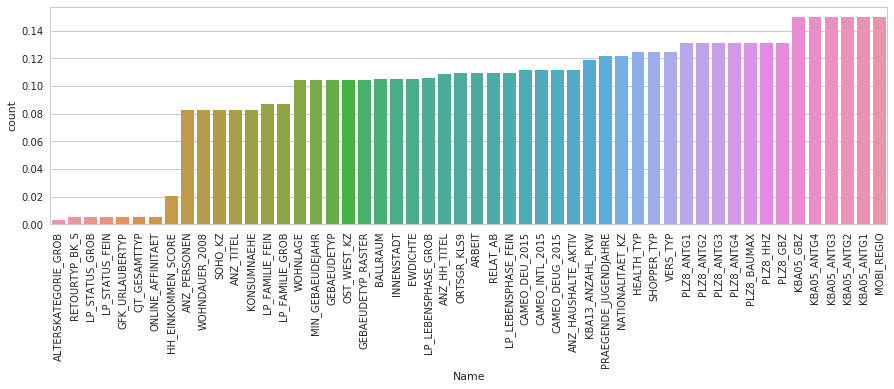

In [20]:
# source: http://theprofessionalspoint.blogspot.com/2019/03/visualize-missing-values-in-bar-plot.html
def viz_missing_values(dataset):
    missing_values = dataset.isnull().sum() / len(dataset)
    missing_values = missing_values[missing_values > 0]
    missing_values.sort_values(inplace=True)
    missing_values

    # Now lets create a pandas dataframe of above result:

    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index

    # We have created two columns ("Name" and "count") in pandas dataframe. Finally, create a bar plot to represent missing values:
    plt.figure(figsize=(15,4))
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x = 'Name', y = 'count', data=missing_values)
    plt.xticks(rotation = 90)
    plt.show()
    
viz_missing_values(azdias_prune_high_na)

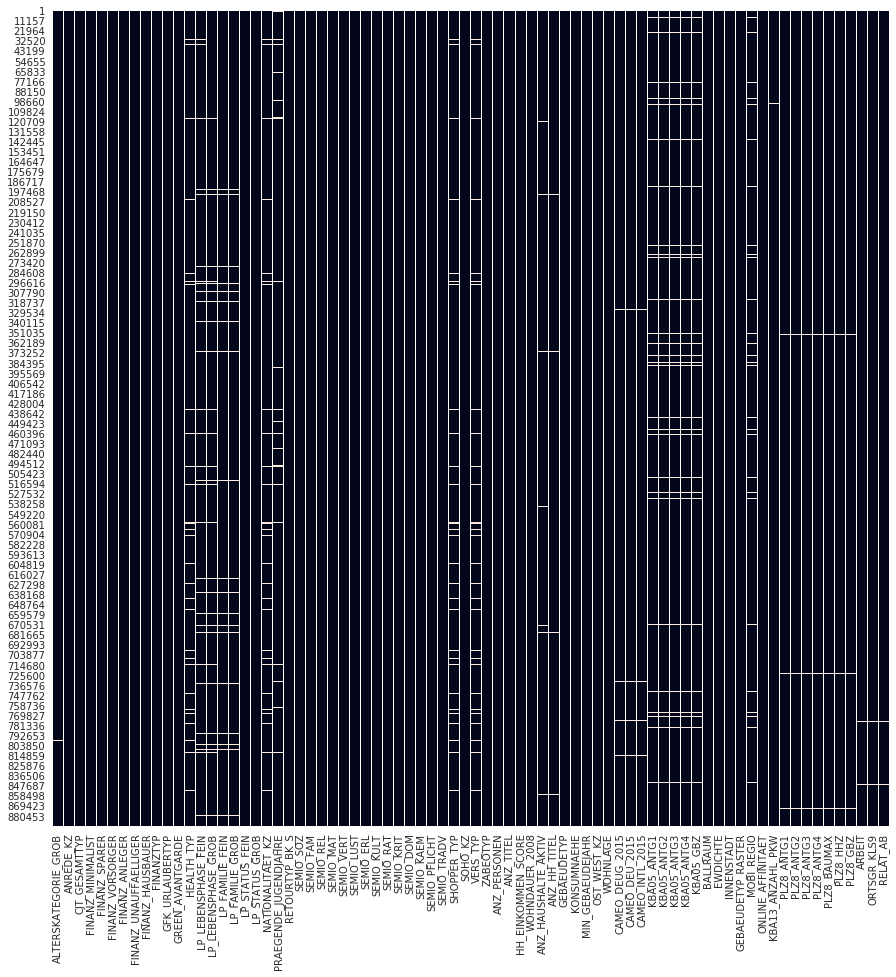

In [21]:
viz_na_heatmap(azdias_below_na)

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.



In [23]:
# Get the top 10 columns with no missing values
top_complete_columns = azdias_threshold_na.notnull().sum().sort_values(ascending=False)[:10].index.tolist()

Comparing 121655 rows with 121655 removed rows 


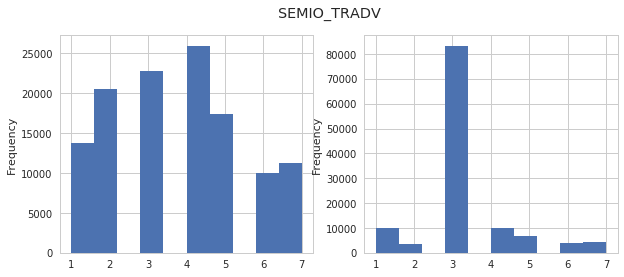

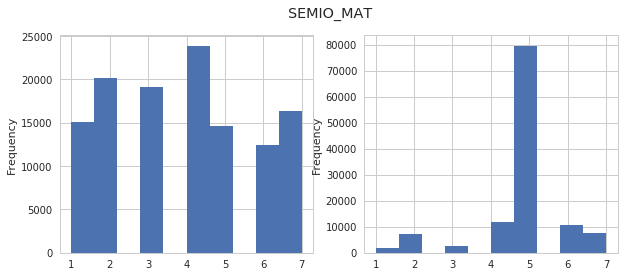

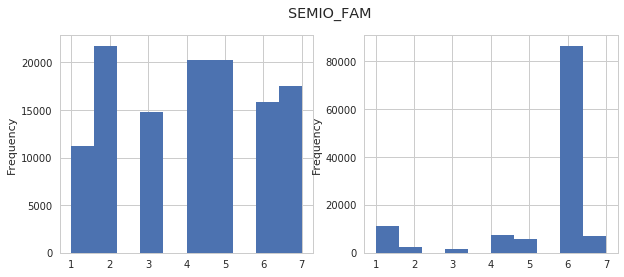

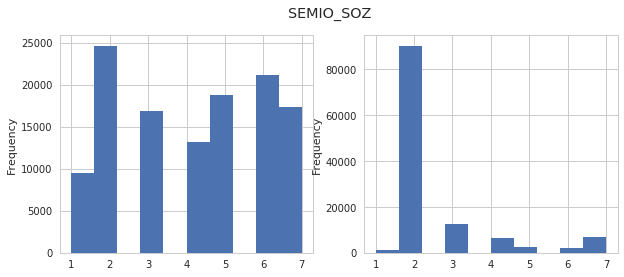

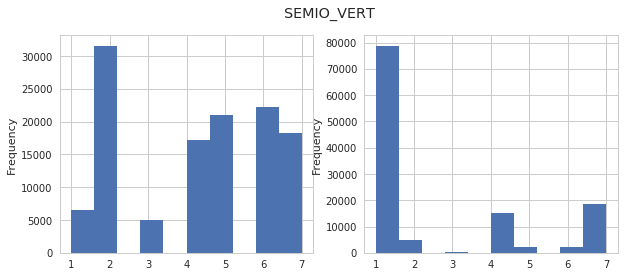

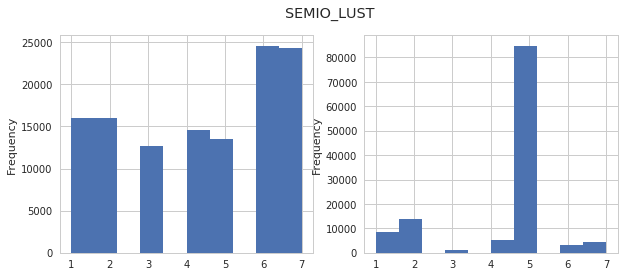

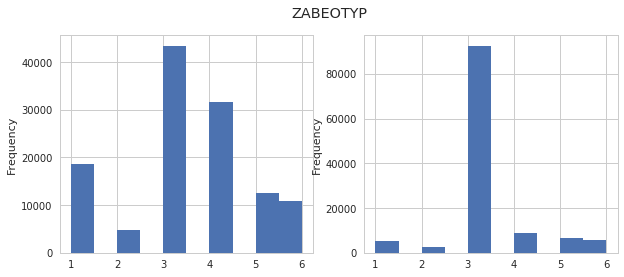

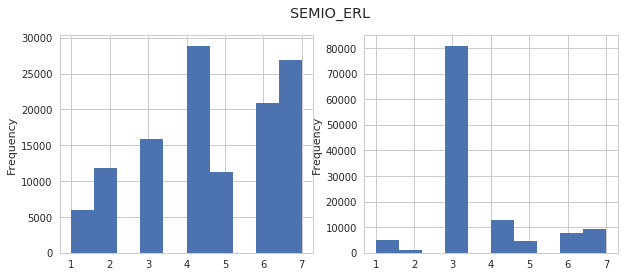

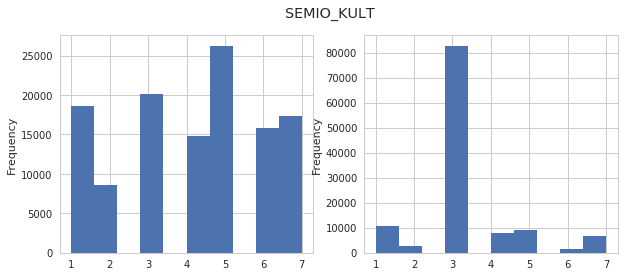

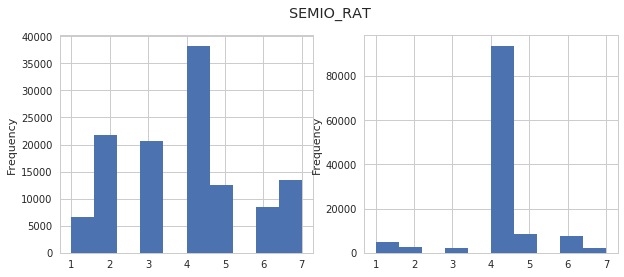

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Make sure the two datasets we're comparing are the same size
thresh_na = azdias_threshold_na
below_na = azdias_below_na.sample(thresh_na.shape[0])

print(f'Comparing {below_na.shape[0]} rows with {thresh_na.shape[0]} removed rows ')

for feature in top_complete_columns:
    try:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        fig.suptitle(feature)
        below_na[feature].plot(kind='hist', ax=axes[0])
        thresh_na[feature].plot(kind='hist', ax=axes[1])
    except Exception as e:
        print('Error:', e)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

We compared the split datasets by separating rows that had less than 10% missing column values from rows that had >= 10% missing column values.  After, we compare their distributions using a histogram.

When comparing the remaining rows vs the removed rows distributions of the top most populated columns, we see that the shapes of all the feature distributions were very different.  A removed row feature distribution consistently had less variance than its counterpart.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def get_categorical_features_by_type(df, feat_info):
    cat_features = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()

    cat_features_by_type = {
        'binary': [],
        'encode': [],
        'object': []
    }

    for feature in cat_features:
        if not feature in df:
            continue

        value_counts = df[feature].value_counts()
        dtypes = df[feature].dtypes
        print(f'\n{feature}')
        print(value_counts)
        print(len(value_counts), dtypes)
        if dtypes == object:
            cat_features_by_type['object'].append(feature)
        elif len(value_counts) == 2:
            cat_features_by_type['binary'].append(feature)
        else:
            cat_features_by_type['encode'].append(feature)
        
    return cat_features_by_type

cat_features_by_type = get_categorical_features_by_type(azdias_below_na, feat_info)


ANREDE_KZ
2.0    401103
1.0    368463
Name: ANREDE_KZ, dtype: int64
2 float64

CJT_GESAMTTYP
4.0    191934
3.0    142506
2.0    138489
5.0    108121
6.0     98102
1.0     90414
Name: CJT_GESAMTTYP, dtype: int64
6 float64

FINANZTYP
6.0    283580
1.0    190002
5.0    102715
2.0    100840
4.0     54259
3.0     38170
Name: FINANZTYP, dtype: int64
6 float64

GFK_URLAUBERTYP
12.0    124264
10.0    100542
8.0      81206
11.0     73302
5.0      69404
4.0      59513
9.0      55237
3.0      52369
1.0      49724
7.0      39503
2.0      39243
6.0      25259
Name: GFK_URLAUBERTYP, dtype: int64
12 float64

GREEN_AVANTGARDE
0.0    600207
1.0    169359
Name: GREEN_AVANTGARDE, dtype: int64
2 float64

LP_FAMILIE_FEIN
1.0     391121
10.0    126520
2.0      95612
11.0     48137
8.0      21251
7.0      18609
4.0      11196
5.0      10935
9.0      10236
6.0       7741
3.0       4381
Name: LP_FAMILIE_FEIN, dtype: int64
11 float64

LP_FAMILIE_GROB
1.0    391121
5.0    184893
2.0     95612
4.0     47601
3.0 

In [27]:
# Attempt to change the object values to float64
def cast_cat_column_object_values(df, cat_features_by_type):
    for feature in cat_features_by_type['object']:
        try:
            df[feature] = df[feature].astype('float64')
            cat_features_by_type['object'].remove(feature)
            cat_features_by_type['encode'].append(feature)
        except Exception as e:
            print('Exception', feature, e)
        
    return cat_features_by_type

cat_features_by_type = cast_cat_column_object_values(azdias_below_na, cat_features_by_type)

Exception OST_WEST_KZ could not convert string to float: 'W'


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
# List out features to encode
for feature in cat_features_by_type['encode']:
    print(azdias_below_na[feature].value_counts())
    print(azdias_below_na[feature].dtypes)

4.0    191934
3.0    142506
2.0    138489
5.0    108121
6.0     98102
1.0     90414
Name: CJT_GESAMTTYP, dtype: int64
float64
6.0    283580
1.0    190002
5.0    102715
2.0    100840
4.0     54259
3.0     38170
Name: FINANZTYP, dtype: int64
float64
12.0    124264
10.0    100542
8.0      81206
11.0     73302
5.0      69404
4.0      59513
9.0      55237
3.0      52369
1.0      49724
7.0      39503
2.0      39243
6.0      25259
Name: GFK_URLAUBERTYP, dtype: int64
float64
1.0     391121
10.0    126520
2.0      95612
11.0     48137
8.0      21251
7.0      18609
4.0      11196
5.0      10935
9.0      10236
6.0       7741
3.0       4381
Name: LP_FAMILIE_FEIN, dtype: int64
float64
1.0    391121
5.0    184893
2.0     95612
4.0     47601
3.0     26512
Name: LP_FAMILIE_GROB, dtype: int64
float64
1.0     202627
9.0     130096
2.0     108760
10.0    108690
4.0      72783
3.0      67692
6.0      28025
5.0      26122
8.0      15818
7.0       8953
Name: LP_STATUS_FEIN, dtype: int64
float64
1.0    31138

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_reencode_cat = pd.get_dummies(azdias_below_na, columns=cat_features_by_type['encode']+cat_features_by_type['object'])
azdias_reencode_cat.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

We decided to keep all the categorical features that we haven't already previously dropped.  Main reason behind this decision: we didn't want to prematurely cut out rich columns out of the dataset.  All non-binary categorical features were able to be one-hot encoded.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def extract_PRAEGENDE_JUGENDJAHRE(df):
    # Extract decade
    PRAEGENDE_JUGENDJAHRE_decade = [np.nan, 40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]

    def PRAEGENDE_JUGENDJAHRE_get_decade(x):
        if pd.isna(x):
            return np.nan
        else:
            return PRAEGENDE_JUGENDJAHRE_decade[int(x)]

    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_get_decade)


    # Extract movement (as binary)
    # 0 = mainstream, 1 = avantgarde
    PRAEGENDE_JUGENDJAHRE_movement = [np.nan, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]

    def PRAEGENDE_JUGENDJAHRE_get_movement(x):
        if pd.isna(x):
            return np.nan
        else:
            return PRAEGENDE_JUGENDJAHRE_movement[int(x)]

    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(PRAEGENDE_JUGENDJAHRE_get_movement)

    # Drop PRAEGENDE_JUGENDJAHRE
    return df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

azdias_reencode_cat = extract_PRAEGENDE_JUGENDJAHRE(azdias_reencode_cat)

In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def extract_CAMEO_INTL_2015(df):
    # Extract wealth
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: (float(x) // 10))

    # Extract life stage typology
    df['CAMEO_INTL_2015_life_typology'] = df['CAMEO_INTL_2015'].apply(lambda x: (float(x) % 10))

    # Drop CAMEO_INTL_2015
    return df.drop(columns=['CAMEO_INTL_2015'])

azdias_reencode_cat = extract_CAMEO_INTL_2015(azdias_reencode_cat)

In [32]:
# Investigate mixed features to see if we can one-hot encode

def get_remaining_mixed_fixtures(df, feat_info):
    mixed_features = []

    # Only add columns to mixed_features if it still exists in the dataset
    for feature in feat_info[feat_info['type'] == 'mixed']['attribute'].tolist():
        if feature in df:
            mixed_features.append(feature)
        
    return mixed_features
        
mixed_features = get_remaining_mixed_fixtures(azdias_reencode_cat, feat_info)

for column in mixed_features:
    print(azdias_reencode_cat[column].value_counts())
    print(azdias_reencode_cat[column].dtypes)

1.0     57714
5.0     51628
6.0     42325
2.0     36520
8.0     28294
7.0     24667
29.0    24544
13.0    24272
11.0    23769
10.0    22603
31.0    22067
12.0    21142
30.0    20725
15.0    18722
3.0     18274
19.0    17775
37.0    17017
4.0     16245
20.0    16076
14.0    15930
32.0    15584
39.0    14981
40.0    14044
16.0    13418
38.0    12809
35.0    12708
27.0    12631
34.0    12001
21.0    11830
9.0     11581
24.0    11133
28.0    11039
25.0     9542
36.0     9537
23.0     7997
22.0     6685
18.0     6063
33.0     5654
17.0     5340
26.0     3256
Name: LP_LEBENSPHASE_FEIN, dtype: int64
float64
2.0     146914
1.0     128753
3.0     103876
12.0     68388
4.0      50204
9.0      45269
5.0      45254
10.0     37651
11.0     30363
8.0      26926
6.0      26512
7.0      20675
Name: LP_LEBENSPHASE_GROB, dtype: int64
float64
3.0    242700
7.0    165304
4.0    131960
2.0     97517
5.0     71744
1.0     42593
8.0     14804
0.0      2944
Name: WOHNLAGE, dtype: int64
float64
1.0    493820
5

In [33]:
# One-hot encode mixed features
azdias_reencode_cat = pd.get_dummies(azdias_reencode_cat, columns=mixed_features)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

After extracting columns for `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`, we investigated the remaining mixed-type features.  We concluded that all of the remaining mixed-type columns were not multi-axes values and they all represented categorical data.  Thus, they were one-hot encoded.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = fill_missing_with_nan(df)
    
    # remove selected columns and rows, ...
    # Drop features with 15% or greater missing values
    feature_na_percentage = get_na_percentage(df)
    na_features = na_features_below_threshold(feature_na_percentage, threshold=.15)
    # Only drop the top 9 so that we do not lose too many features
    na_features = na_features[:9]
    print(f'Dropping {len(na_features)} Features:', na_features)
    df = df.drop(axis=1, columns=na_features)
    
    # Drop rows with missing data at or above a 10% threshold
    rows_missing = get_rows_missing_apply(df)
    df, _ = split_rows_missing(df, rows_missing, threshold=.1)

    # select, re-encode, and engineer column values.
    cat_features_by_type = get_categorical_features_by_type(df, feat_info)
    # Attempt to change the object values to float64
    cat_features_by_type = cast_cat_column_object_values(df, cat_features_by_type)
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df = pd.get_dummies(df, columns=cat_features_by_type['encode']+cat_features_by_type['object'])
    try:
        df = extract_PRAEGENDE_JUGENDJAHRE(df)
    except Exception as e:
        print('extract_PRAEGENDE_JUGENDJAHRE Exception:', e)
    try:
        df = extract_CAMEO_INTL_2015(df)
    except Exception as e:
        print('extract_CAMEO_INTL_2015 Exception:', e)
    
    # One-hot encode mixed features
    mixed_features = get_remaining_mixed_fixtures(df, feat_info)
    df = pd.get_dummies(df, columns=mixed_features)
    
    # Return the cleaned dataframe.
    return df
    

In [37]:
# Compare clean_data result with azdias_reencode_cat
print(azdias_reencode_cat.info())

start = time.time()
cleaned_data = clean_data(azdias)
end = time.time()
print(cleaned_data.info())
print("took %.6f seconds to process" % (end - start))

cleaned_data.equals(azdias_reencode_cat)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 769566 entries, 1 to 891220
Columns: 255 entries, ALTERSKATEGORIE_GROB to PLZ8_BAUMAX_5.0
dtypes: float64(60), uint8(195)
memory usage: 501.3 MB
None
Dropping 9 Features: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'REGIOTYP', 'KKK', 'W_KEIT_KIND_HH']

ANREDE_KZ
2.0    401103
1.0    368463
Name: ANREDE_KZ, dtype: int64
2 float64

CJT_GESAMTTYP
4.0    191934
3.0    142506
2.0    138489
5.0    108121
6.0     98102
1.0     90414
Name: CJT_GESAMTTYP, dtype: int64
6 float64

FINANZTYP
6.0    283580
1.0    190002
5.0    102715
2.0    100840
4.0     54259
3.0     38170
Name: FINANZTYP, dtype: int64
6 float64

GFK_URLAUBERTYP
12.0    124264
10.0    100542
8.0      81206
11.0     73302
5.0      69404
4.0      59513
9.0      55237
3.0      52369
1.0      49724
7.0      39503
2.0      39243
6.0      25259
Name: GFK_URLAUBERTYP, dtype: int64
12 float64

GREEN_AVANTGARDE
0.0    600207
1.0    169359
Name: GREEN

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

dropped_na = cleaned_data.dropna(how='any')
dropped_diff = cleaned_data.shape[0] - dropped_na.shape[0]
print('If we drop all rows with any missing values, we lose %.1f%% of rows.' % (dropped_diff / cleaned_data.shape[0] * 100))

If we drop all rows with any missing values, we lose 10.5% of rows.


In [39]:
# Apply feature scaling to the general population demographics data.

def scale_features(df):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(df.values)
    return pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

scaled = scale_features(dropped_na)
scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
1,-1.738330,0.977328,-1.512418,1.575956,-1.042476,1.509267,1.039530,1.344051,-0.543995,1.034049,...,-0.685820,2.192838,-0.317746,-0.529412,-0.112596,0.749231,-0.318186,-0.267888,-0.283587,-0.380033
2,0.203789,0.977328,-1.512418,0.896193,-1.763660,-0.552949,0.312296,1.344051,1.838251,1.034049,...,-0.685820,-0.456030,-0.317746,-0.529412,-0.112596,0.749231,-0.318186,-0.267888,-0.283587,-0.380033
3,1.174849,0.977328,0.685640,-0.463333,1.121078,-0.552949,-1.142171,-0.835955,-0.543995,-0.288809,...,-0.685820,-0.456030,-0.317746,1.888889,-0.112596,0.749231,-0.318186,-0.267888,-0.283587,-0.380033
4,0.203789,-1.023197,0.685640,0.216430,0.399894,-1.240354,0.312296,-0.835955,-0.543995,1.034049,...,1.458109,-0.456030,-0.317746,-0.529412,-0.112596,-1.334702,3.142817,-0.267888,-0.283587,-0.380033
5,-1.738330,0.977328,-0.047046,-1.143095,1.121078,-0.552949,-0.414937,1.344051,-0.543995,1.034049,...,-0.685820,-0.456030,-0.317746,1.888889,-0.112596,0.749231,-0.318186,-0.267888,-0.283587,-0.380033


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

We decided to scale the features with StandardScaler over MinMaxScaler because PCA-transformation calculation requires two properties: zero-mean and unit-variance. MinMaxScaler lacks unit-variance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.
def do_pca(scaled_data, n_components=None):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(scaled_data)
    return pca, X_pca

pca, X_pca = do_pca(scaled)

In [ ]:
# Investigate the variance accounted for by each principal component.

# scree_plot taken from course helper_functions.py
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        if i % 10 == 0:
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 120
pca, X_pca = do_pca(scaled, n_components=n_components)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

After analyzing the variance of PCA applied to all components, we decided to keep 120 components moving forward.  At 120 components, we capture over 80% of explained variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = ['pc_{}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys(), index=dimensions)

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['explained_variance'])
	variance_ratios.index = dimensions

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

pca_weights = pca_results(scaled, pca)
pca_weights.head()

In [ ]:
# Get first component weights
# Sort the shit
def get_pca_sorted_feature(pca_weights, n_component, edge_k=None):
    index = f'pc_{n_component}'
    sorted = pca_weights.loc[index, :].drop('explained_variance').sort_values(ascending=False)
    if edge_k != None:
        return pd.concat([sorted.head(edge_k), sorted.tail(edge_k)])
    
    return sorted

get_pca_sorted_feature(pca_weights, 1, edge_k=3)

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_pca_sorted_feature(pca_weights, 2, edge_k=3)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_pca_sorted_feature(pca_weights, 3, edge_k=3)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

We analyzed the top influential features on the top three priciple components (PC) and searched for any meaningful correlations.  

The 1st PC had opposing correlation between `PLZ8_ANTG3` and `KBA05_ANTG1`, both having to do with home-ownership. `PLZ8_ANTG3` accounts for larger family homes while `KBA05_ANTG1` accounts for smaller (1-2 family-sized) homes. `HH_EINKOMMEN_SCORE`, estimated household net income was also negatively correlated to `FINANZ_MINIMALIST`, the financial tendency to have not much interest in one's finances.

The 2nd PC had `ZABEOTYP_3.0`, "fair supplied" energy consumption typology, `ALTERSKATEGORIE_GROB`, estimated age, and `FINANZ_VORSORGER`, financial topology with preparedness as a investment focus.  Interestingly, `FINANZ_VORSORGER`, financial topology with preparedness as a focus and `FINANZ_SPARER`, financial focus on saving, were negatively correlated, hinting that individuals either save their liquidity intentionally for economic hardships or save, but not focus on both strategies. Another odd negative correlation was `ALTERSKATEGORIE_GROB`, estimated age, vs `PRAEGENDE_JUGENDJAHRE_decade`, dominating movement of a person's youth.  That inverse relationship is not very obvious at the moment.

The 3rd PC was dominated by personality topology.  It showed that personality traits like _dreamful_, _socially-minded_, and _family-minded_ we're reversely correlated to _dominant-minded_ and _combative_ traits in individuals.

Of the top three PC's, the third gave the most obvious insights.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Put pca data into dataframe
pca_df = pca_weights.drop('explained_variance', axis=1)
pca_df.head()

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

# KMeans frequently runs into MemoryError.  
# Use MiniBatchKMeans instaed so you don't waste your whole life waiting on a MemoryError.
def get_kmeans_score(data, centroids, minibatch=True):
    if minibatch:
        model = MiniBatchKMeans(n_clusters=centroids, random_state=42, batch_size=100)
    else:
        model = KMeans(n_clusters=centroids, random_state=42)
        
    model = model.fit(data)
    score = model.score(data)
    return np.abs(score)

scores = []
centers = range(1, 25)

for center in centers:
    scores.append(get_kmeans_score(X_pca, center))
    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('MiniBatchKMeans');

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 15
model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
model = model.fit(X_pca)
preds = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.info()

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)
customers.info()

In [ ]:
# Drop all rows with any missing values
customers_nona = customers.dropna(how='any')

# Feature Scale
customers_scaled = scale_features(customers_nona)

# Apply PCA
cus_pca, cus_X_pca = do_pca(customers_scaled)
scree_plot(cus_pca)

In [ ]:
# Apply PCA that will capture +80% of explained variance
cus_pca, cus_X_pca = do_pca(customers_scaled, n_components=n_components)
cus_preds = model.predict(cus_X_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.